In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import keras
from keras import backend as K
from keras.models import load_model
from keras.datasets import mnist
from keras import metrics
from keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Load dataset

In [2]:
'''Load MNIST dataset'''
(x_all, y_all), (x_test, y_test) = mnist.load_data()
x_train = x_all[:50000]
y_train = y_all[:50000]

x_validate = x_all[50000:]
y_validate = y_all[50000:]

#Normal dataset
x_train = x_train.astype('float32') / 255.
x_validate = x_validate.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.expand_dims(x_train, 3)
x_validate = np.expand_dims(x_validate, 3)
x_test = np.expand_dims(x_test, 3)

y_train = to_categorical(y_train, num_classes = 10)
y_validate = to_categorical(y_validate, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

## Load classifier model

In [3]:
classifier = load_model('classifier_.h5') 
classifier.compile(Adam(),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [4]:
'''Test our classifier accuracy on test set'''
_, accuracy = classifier.evaluate(x_test,y_test)
print('Accuracy on test set: %.2f%%' % (accuracy * 100.))

10000/10000 [==============================] - 1s 72us/step
Accuracy on test set: 98.48%


# Generate adversarial examples

In [5]:
'''Get the model loss, recall y = ground truth label'''
y = K.variable(y_test) 
loss = metrics.categorical_crossentropy(classifier.output, y) # crossentropy loss

'''Define function to calculate gradient'''
get_gradients = K.function([classifier.input], K.gradients(loss, classifier.input))

'''Get the gradients w.r.t. each input'''
grads = get_gradients([x_test])[0] # index 0 because get_gradients returns a list of gradients

'''Get the sign of the gradients'''
gradient_signs = np.sign(grads)

In [6]:
epsilon = 0.2
perturbations = epsilon * gradient_signs # perturbation = ϵ * sign(gradient)
adv_imgs = x_test + perturbations # x' = x + perturbations
adv_imgs = np.clip(adv_imgs, 0.0, 1.0) # make sure they are within bound

## Let's see the adversarial examples

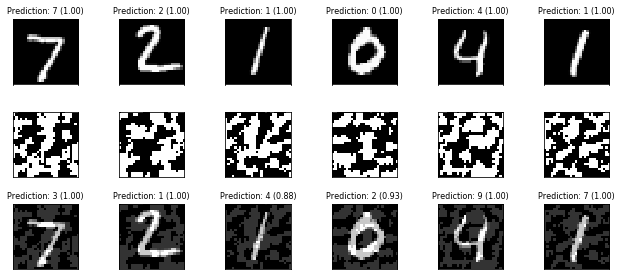

In [7]:
'''Show some adversarial images and the predictions of the classifier'''
prediction = classifier.predict(x_test) # prediction on clean examples
adv_pred = classifier.predict(adv_imgs) # prediction on adversarial examples

fig,ax = plt.subplots(nrows = 3, ncols = 6, figsize = (9,4))
for i in range(6):
    '''Display original images'''
    ax[0,i].imshow(x_test[i,:,:,0], cmap = 'gray')
    title = 'Prediction: ' + str(np.argmax(prediction[i]))\
            + ' (' +\
            '%.2f' % (np.amax(prediction[i]))\
            + ')'
    ax[0,i].set_title(title, fontsize = 8)
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    '''Display perturbations'''
    ax[1,i].imshow(perturbations[i,:,:,0], cmap = 'gray')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    '''Display adversarial images'''
    ax[2,i].imshow(adv_imgs[i,:,:,0], cmap = 'gray')
    title = 'Prediction: ' + str(np.argmax(adv_pred[i]))\
            + ' (' +\
            '%.2f' % (np.amax(adv_pred[i]))\
            + ')'
    ax[2,i].set_title(title, fontsize = 8)
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

## Check the accuracy of the model on adversarial examples

In [8]:
'''Test our classifier accuracy on test set'''
_, adv_accuracy = classifier.evaluate(adv_imgs,y_test)
print('Accuracy on adversarial test set: %.2f%%' % (adv_accuracy * 100.))

10000/10000 [==============================] - 0s 22us/step
Accuracy on adversarial test set: 3.79%
